# <center> <u> Cox Ingersoll Ross Model </u> </center> 

In [1]:
import requests
import numpy as np
import pandas as pd 

from numba import jit, prange
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt 

from sklearn.linear_model import LinearRegression

## <center> Set Seaborn Theme </center>

In [2]:
sns.set_theme(
    style = "darkgrid",
    palette = "bright",
)

plt.rc('figure', figsize = (10, 5))

## <center> Estimate Parameters of CIR Model </center> 

## <center> $ dr = a(b - r) \cdot dt + \sigma \sqrt{r} dz $ </center> 

In [3]:
df = pd.read_excel("Data/VasicekCIR.xls", sheet_name = "Data (See Section 31.4)", skipfooter = 1)

In [4]:
df.head()

,Date,3 mnth rate(%),Rate (decimal),Change
0,1982-01-04,11.87,0.1187,0.0033
1,1982-01-05,12.20,0.1220,-0.0004
2,1982-01-06,12.16,0.1216,0.0001
3,1982-01-07,12.17,0.1217,-0.0019
4,1982-01-08,11.98,0.1198,0.0051


In [5]:
df.tail()

,Date,3 mnth rate(%),Rate (decimal),Change
8658,2016-08-16,0.27,0.0027,0.0003
8659,2016-08-17,0.30,0.0030,0.0000
8660,2016-08-18,0.30,0.0030,0.0000
8661,2016-08-19,0.30,0.0030,-0.0001
8662,2016-08-22,0.29,0.0029,0.0001


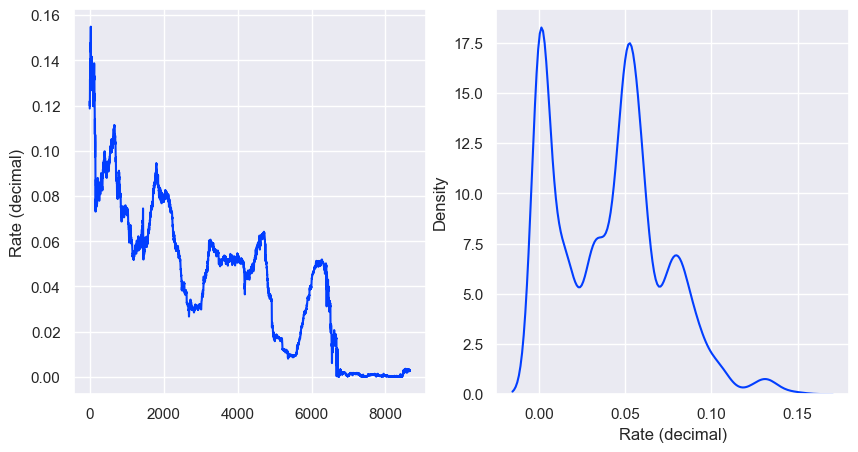

In [6]:
fig, axes = plt.subplots(1, 2)

sns.lineplot(
    df["Rate (decimal)"],
    ax = axes[0]
)

sns.kdeplot(
    df["Rate (decimal)"],
    ax = axes[1]
)

plt.show()

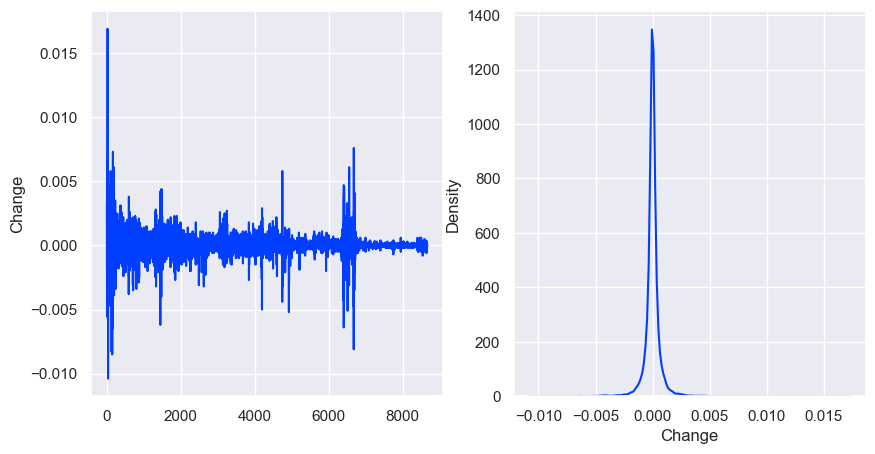

In [7]:
fig, axes = plt.subplots(1, 2)

sns.lineplot(
    df["Change"],
    ax = axes[0]
)

sns.kdeplot(
    df["Change"],
    ax = axes[1],
)

plt.show()

## <center> Optimize with Linear Regression </center>

In [8]:
X = df["Rate (decimal)"].to_numpy()
y = df["Change"].to_numpy()

In [9]:
model = LinearRegression().fit(X.reshape(-1, 1), y)
pred = model.predict(X.reshape(-1, 1))

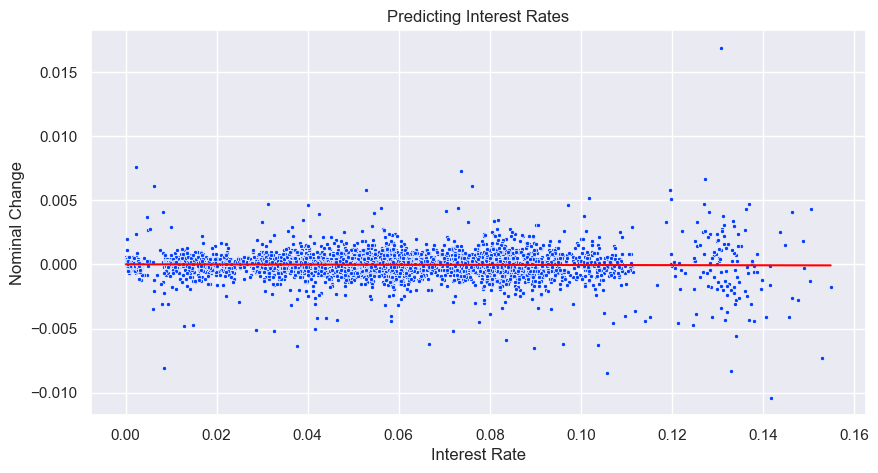

In [10]:
ax = sns.scatterplot(
    x = X,
    y = y,
    marker = "."
)

sns.lineplot(
    x = X,
    y = pred, 
    color = "red"
)

ax.set(
    title = "Predicting Interest Rates",
    xlabel = "Interest Rate",
    ylabel = "Nominal Change",
)

plt.show()

## <center> Optimized Model Parameters </center>

## <center> $ r_{i+1} - r_{i} = a + b \cdot r_{i} $ </center>

In [10]:
dt = 1 / 252

In [11]:
beta = np.abs(model.coef_[0])
print("Slope of Regression Model: ", beta)

Slope of Regression Model:  0.0005446147281124361


In [12]:
reversion_rate = beta * 252
print("Reversion Rate (a): ", reversion_rate)

Reversion Rate (a):  0.1372429114843339


In [13]:
intercept = model.intercept_
print("Intercept of Regression Model: ", intercept)

Intercept of Regression Model:  9.146996484883851e-06


In [14]:
reversion_level = intercept  / beta
print("Reversion Level (b): ", reversion_level)

Reversion Level (b):  0.016795352774586454


## <center> $ SE = \sqrt{\frac{\sum_{i=1}^{N} (y_{i} - \hat{y})^{2}}{N}} $ </center>

In [15]:
standard_error = np.sqrt(np.sum((pred - y)**2 / len(y)))
print("Standard Error of Regression Model: ", standard_error)

Standard Error of Regression Model:  0.0007539462515063936


In [16]:
volatility = standard_error * np.sqrt(252)
print("Volatility: ", volatility)

Volatility:  0.011968525700371649


## <center> Monte Carlo Simulation </center> 

## <center> $ \Delta r = a(b - r) \cdot dt + \sigma \sqrt{r} \epsilon \sqrt{\Delta t}$ </center>

In [11]:
@jit(nopython = True)
def cir_monte_carlo():
    """
    
    """
    
    a = 0.13724
    b = 0.01679 * 100
    sigma = 0.01196 * 100
    
    dt = 1 / 252
    sim_count = 100
    sim_length = 252
    arr = np.zeros((sim_count, sim_length))
    
    for i in range(sim_count):
        
        rv = np.random.normal(0, 1, sim_length)
        tmp = np.zeros(sim_length)
        tmp[0] = b
        
        for j in range(1, sim_length):
            
            tmp[j] = tmp[j - 1] + (a * (b - tmp[j - 1]) * dt) + (sigma * np.sqrt(tmp[j-1]) * rv[j] * np.sqrt(dt))
            
        arr[i] = tmp
    
    return arr

In [12]:
mc = cir_monte_carlo().T

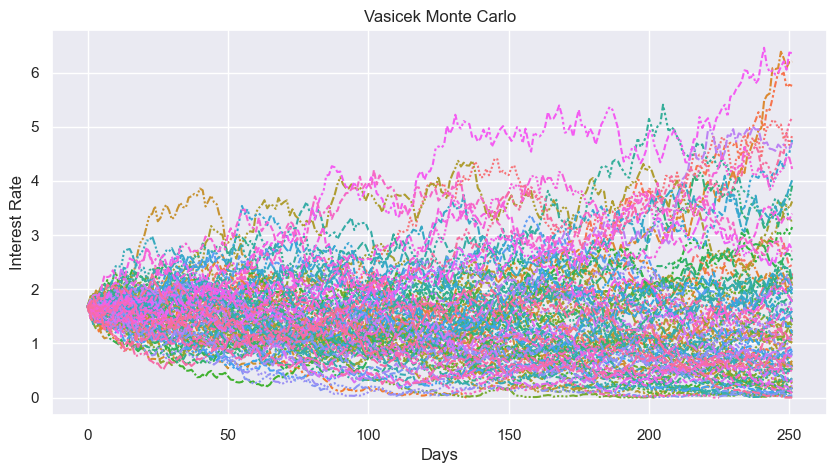

In [13]:
ax = sns.lineplot(mc, legend = False)

ax.set(
    title = "Vasicek Monte Carlo",
    xlabel = "Days",
    ylabel = "Interest Rate",
)

plt.show()